In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  #0 white 1 black 2 chinese 3 indian 4 hispanic
import pandas as pd
import cv2
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import asarray 
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.transforms import ToPILImage, ToTensor
import re
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import classification_report
import gc
torch.cuda.empty_cache()
gc.collect()

#for dirname, _, filenames in os.walk('/kaggle/input/utkface-new/UTKFace'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))   
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

0

In [30]:
DATA_DIR = "/kaggle/input/utkface-new/UTKFace"
TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198
ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = dict((g, i) for i, g in ID_GENDER_MAP.items())
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())

ID_GENDER_MAP, GENDER_ID_MAP, ID_RACE_MAP, RACE_ID_MAP

({0: 'male', 1: 'female'},
 {'male': 0, 'female': 1},
 {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'},
 {'white': 0, 'black': 1, 'asian': 2, 'indian': 3, 'others': 4})

In [31]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), ID_GENDER_MAP[int(gender)], ID_RACE_MAP[int(race)]
    except Exception as e:
        print(filepath)
        return None, None, None

In [32]:
# create a pandas data frame of images, age, gender and race
files = glob.glob(os.path.join(DATA_DIR, "*.jpg"))
attributes = list(map(parse_filepath, files))

/kaggle/input/utkface-new/UTKFace/61_1_20170109142408075.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/61_1_20170109150557335.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/39_1_20170116174525125.jpg.chip.jpg


In [33]:
df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['age', 'gender', 'race', 'file']
df = df.dropna()
df.head()

,age,gender,race,file
0,26.0,male,asian,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...
1,22.0,female,black,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...
2,21.0,female,indian,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...
3,28.0,male,white,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...
4,17.0,female,others,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...


In [34]:
# Under-sample the 'white' class
white_df = df[df['race'] == 'white']
non_white_df = df[df['race'] != 'white']

In [35]:
# Set the desired count, for instance, equalize it to the count of the 'black' class 
desired_white_count = df[df['race'] == 'black'].shape[0]
white_df = white_df.sample(n=desired_white_count, random_state=42)

# Under-sample age values of 26
age_26_df = df[df['age'] == 26]
non_age_26_df = df[df['age'] != 26]

# Set the desired count, median of the age counts for demonstration
median_age_count = int(df['age'].value_counts().median())
age_26_df = age_26_df.sample(n=median_age_count, random_state=42)

In [36]:
# Concatenate the separate DataFrames back together
df = pd.concat([white_df, non_white_df, age_26_df, non_age_26_df])

In [37]:
# Shuffle the DataFrame rows
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [38]:
df.describe()

,age
count,39808.000000
mean,33.028311
std,19.960382
min,1.000000
25%,22.000000
50%,30.000000
75%,45.000000
max,116.000000


In [39]:
# from imblearn.over_sampling import SMOTE

# # Convert gender and race to numerical values for the SMOTE operation
# df['gender_id'] = df['gender'].map(lambda gender: GENDER_ID_MAP[gender])
# df['race_id'] = df['race'].map(lambda race: RACE_ID_MAP[race])

# # Extract features excluding 'file' and target variable
# X = df[['age', 'gender_id']]
# y = df['race_id']

# # Store the file column separately to join it later
# file_column = df['file']

# # Initialize SMOTE
# smote = SMOTE(sampling_strategy={RACE_ID_MAP['others']: desired_white_count}, random_state=42)

# # Apply SMOTE to our data
# X_resampled, y_resampled = smote.fit_resample(X, y)

# # Creating a new DataFrame from the resampled data
# df_resampled = pd.DataFrame(X_resampled, columns=['age', 'gender_id'])
# df_resampled['race_id'] = y_resampled

# # Mapping back the race_id and gender_id to their categorical values
# df_resampled['race'] = df_resampled['race_id'].map(lambda race_id: ID_RACE_MAP[race_id])
# df_resampled['gender'] = df_resampled['gender_id'].map(lambda gender_id: ID_GENDER_MAP[gender_id])

# df_resampled = df_resampled.join(file_column)

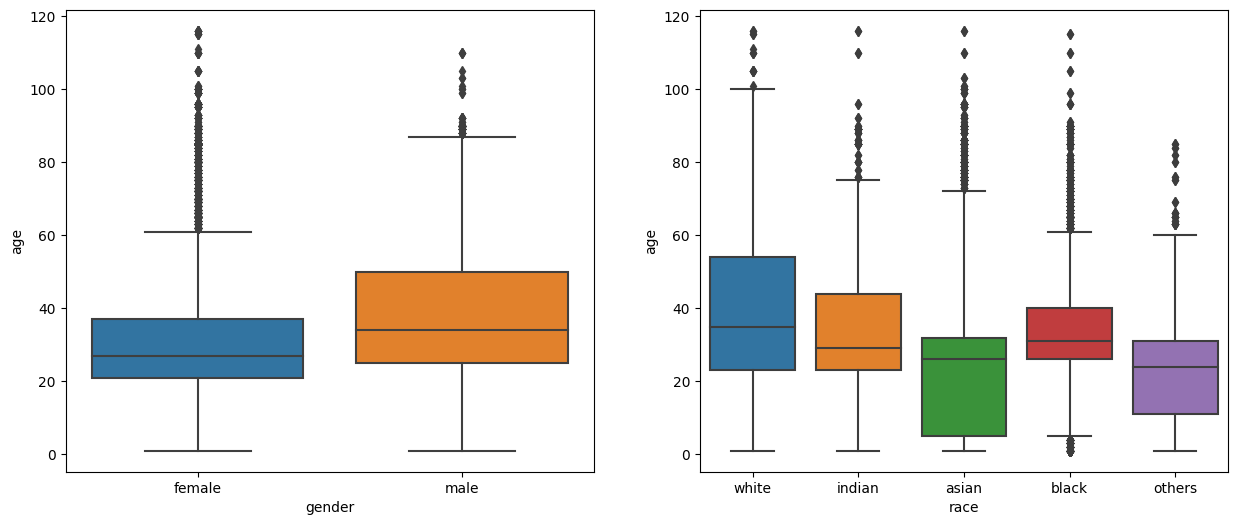

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.boxplot(data=df, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)

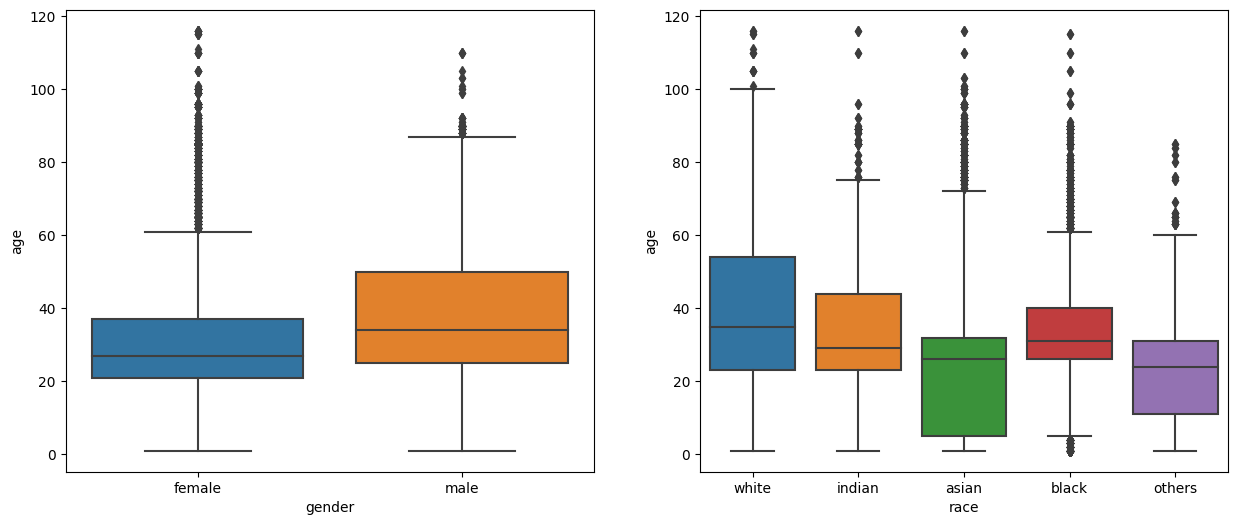

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.boxplot(data=df, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)

<Axes: xlabel='gender', ylabel='age'>

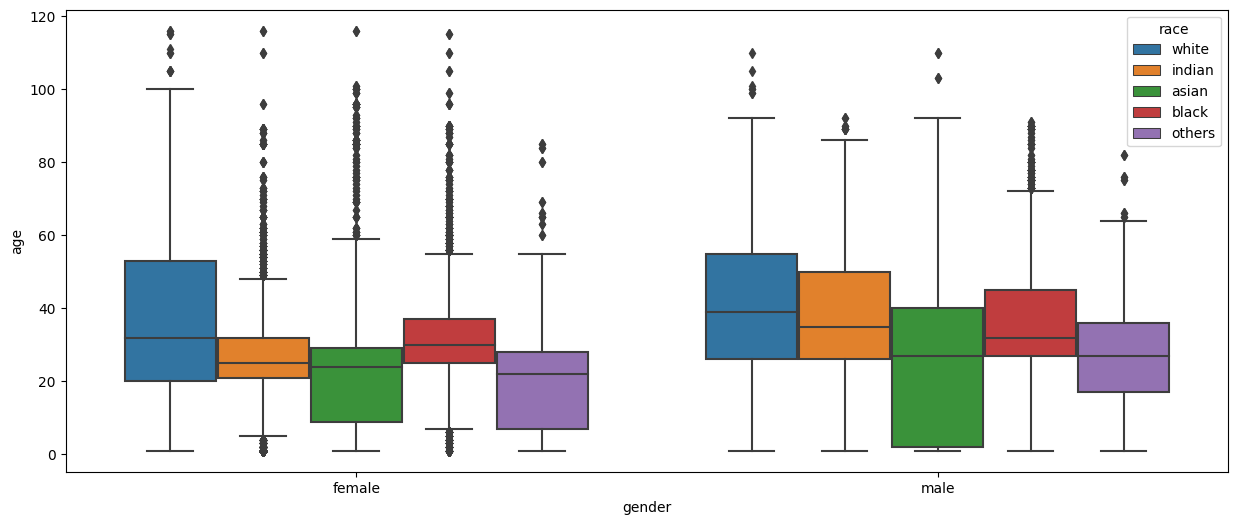

In [42]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='gender', y='age', hue='race')

<Axes: xlabel='race,gender'>

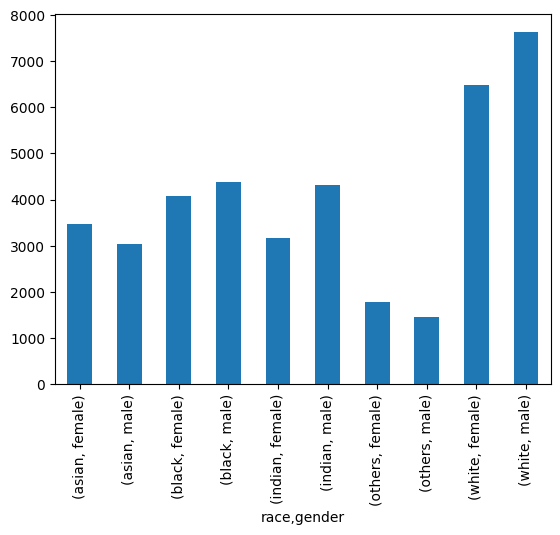

In [43]:
df.groupby(by=['race', 'gender'])['age'].count().plot(kind='bar')

<Axes: >

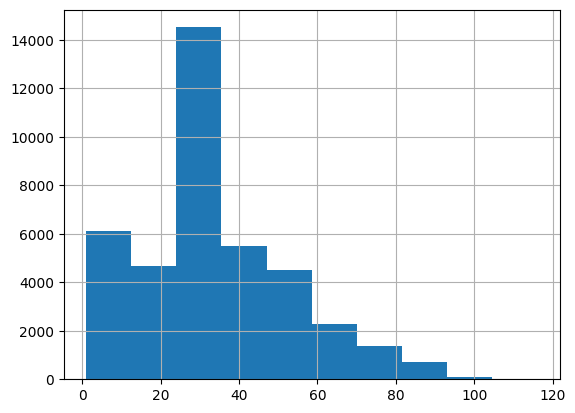

In [44]:
df['age'].hist()

In [45]:
df['age'].describe()
df = df[(df['age'] > 10) & (df['age'] < 70)]

In [46]:
# # Calculate the number of samples to be added for the 'others' race
# majority_count = df['race'].value_counts().max()  # This will give you the count of the race with the highest number of samples
# others_count = df[df['race'] == 'others'].shape[0]
# samples_to_add = majority_count - others_count

# # Randomly sample samples_to_add number of rows from the 'others' race
# oversampled_others_df = df[df['race'] == 'others'].sample(samples_to_add, replace=True, random_state=42)

# # Add these to the original DataFrame
# df = pd.concat([df, oversampled_others_df])

# # Shuffle the DataFrame rows
# df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [47]:
p = np.random.permutation(len(df))
train_up_to = int(len(df) * TRAIN_TEST_SPLIT)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

df['gender_id'] = df['gender'].map(lambda gender: GENDER_ID_MAP[gender])
df['race_id'] = df['race'].map(lambda race: RACE_ID_MAP[race])

max_age = df['age'].max()
len(train_idx), len(valid_idx), len(test_idx), max_age

(19763, 8471, 12101, 69.0)

In [48]:
class UTKFaceDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 3]
        image = Image.open(img_name)
        age = self.df.iloc[idx, 0] / max_age
        race = torch.zeros(len(RACE_ID_MAP))
        race[self.df.iloc[idx, 5]] = 1
        gender = torch.zeros(2)
        gender[self.df.iloc[idx, 4]] = 1

        if self.transform:
            image = self.transform(image)

        return image, age, race, gender

transform = transforms.Compose([
    transforms.Resize((IM_WIDTH, IM_HEIGHT)),
    transforms.ToTensor(),
])

dataset = UTKFaceDataset(df, transform)

train_loader = DataLoader(dataset, batch_size=64, sampler=SubsetRandomSampler(train_idx))
valid_loader = DataLoader(dataset, batch_size=64, sampler=SubsetRandomSampler(valid_idx))
test_loader = DataLoader(dataset, batch_size=128, sampler=SubsetRandomSampler(test_idx))


In [49]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler

class Backbone(nn.Module):
    def __init__(self):
        super(Backbone, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.layers(x)

class AgeHead(nn.Module):
    def __init__(self):
        super(AgeHead, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 6 * 6, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.layers(x)

class RaceHead(nn.Module):
    def __init__(self):
        super(RaceHead, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4),

            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 5)
        )

    def forward(self, x):
        return F.softmax(self.layers(x), dim=1)

class GenderHead(nn.Module):
    def __init__(self):
        super(GenderHead, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 6 * 6, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        return F.softmax(self.layers(x), dim=1)

class MultiTaskModel(nn.Module):
    def __init__(self):
        super(MultiTaskModel, self).__init__()
        self.backbone = Backbone()
        self.age_head = AgeHead()
        self.race_head = RaceHead()
        self.gender_head = GenderHead()

    def forward(self, x):
        features = self.backbone(x)
        age = self.age_head(features)
        race = self.race_head(features)
        gender = self.gender_head(features)
        return age, race, gender

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskModel().to(device)
model = model.float()

criterion_age = nn.MSELoss()
criterion_race = nn.CrossEntropyLoss()
criterion_gender = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Decays LR every 10 epochs by a factor of 0.1

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, loader, num_images=5):
    model.eval()
    image_count = 0
    fig, axs = plt.subplots(num_images, figsize=(10, 5 * num_images))

    with torch.no_grad():
          for images, ages, races, genders in loader:
            if image_count >= num_images:
#         for idx, (images, ages, races, genders) in enumerate(loader):
#             if idx == num_images:
                break

            images = images.float().to(device)
            age_preds, race_preds, gender_preds = model(images)

            _, predicted_races = torch.max(race_preds, 1)
            _, predicted_genders = torch.max(gender_preds, 1)

            for i in range(images.size(0)):
                if image_count >= num_images:
                    break
            # Convert the predictions back to the label names
            pred_age = int(age_preds[i].squeeze().item() * max_age)
            true_age = int(ages[i].item() * max_age)

            # Assuming you have a reverse dictionary to map from label ID back to race name
#             pred_race = REVERSE_RACE_ID_MAP[predicted_races.item()]  
#             true_race = REVERSE_RACE_ID_MAP[torch.argmax(races, dim=1).item()]

            pred_race = ID_RACE_MAP[predicted_races[i].item()]
            true_race = ID_RACE_MAP[torch.argmax(races[i], dim=0).item()]


#             pred_gender = "Male" if predicted_genders.item() == 1 else "Female"
#             true_gender = "Male" if torch.argmax(genders, dim=1).item() == 1 else "Female"
            pred_gender = "Female" if predicted_genders[i].item() == 1 else "Male"
            true_gender = "Female" if torch.argmax(genders[i], dim=0).item() == 1 else "Male"
                
            # Plotting the image with predictions and true labels
#             axs[idx].imshow(np.transpose(images[0].cpu().numpy(), (1, 2, 0)))
#             axs[idx].axis('off')
#             axs[idx].set_title(f"True: {true_age} years, {true_race}, {true_gender}\nPred: {pred_age} years, {pred_race}, {pred_gender}")
            axs[image_count].imshow(np.transpose(images[i].cpu().numpy(), (1, 2, 0)))
            axs[image_count].axis('off')
            axs[image_count].set_title(f"True: {true_age} years, {true_race}, {true_gender}\nPred: {pred_age} years, {pred_race}, {pred_gender}")
                
            image_count += 1

    plt.tight_layout()
    plt.show()

# Visualize the predictions on the validation dataset
visualize_predictions(model, valid_loader)

In [42]:
import time
import matplotlib.pyplot as plt

# Initialization
num_epochs = 100

# Lists to hold running losses for plotting
train_loss_age = []
train_loss_race = []
train_loss_gender = []
train_total_loss = []

# Lists to hold validation losses
valid_loss_age = []
valid_loss_race = []
valid_loss_gender = []
valid_total_loss = []

# Start the timer
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss_age = 0
    epoch_train_loss_race = 0
    epoch_train_loss_gender = 0
    epoch_train_total_loss = 0
    total_samples = 0
    
    for images, ages, races, genders in train_loader:
        images, ages, races, genders = images.float().to(device), ages.float().to(device), races.float().to(device), genders.float().to(device)
        
        optimizer.zero_grad()
        age_preds, race_preds, gender_preds = model(images)
        age_preds = age_preds.squeeze(1)
        
        loss_age = criterion_age(age_preds, ages)
        loss_race = criterion_race(race_preds, torch.argmax(races, dim=1))
        loss_gender = criterion_gender(gender_preds, torch.argmax(genders, dim=1))
        loss = 2*loss_age + 1.5*loss_race + loss_gender  
        
        loss.backward()
        optimizer.step()
        
        # Update the running losses
        epoch_train_loss_age += loss_age.item() * len(images)
        epoch_train_loss_race += loss_race.item() * len(images)
        epoch_train_loss_gender += loss_gender.item() * len(images)
        epoch_train_total_loss += loss.item() * len(images)
        total_samples += len(images)
    
    # Compute validation loss
    model.eval()
    epoch_valid_loss_age = 0
    epoch_valid_loss_race = 0
    epoch_valid_loss_gender = 0
    epoch_valid_total_loss = 0
    valid_samples = 0
    
    with torch.no_grad():
        for images, ages, races, genders in valid_loader:
            images, ages, races, genders = images.float().to(device), ages.float().to(device), races.float().to(device), genders.float().to(device)
            
            age_preds, race_preds, gender_preds = model(images)
            age_preds = age_preds.squeeze(1)
            
            loss_age = criterion_age(age_preds, ages)
            loss_race = criterion_race(race_preds, torch.argmax(races, dim=1))
            loss_gender = criterion_gender(gender_preds, torch.argmax(genders, dim=1))
            loss = 2*loss_age + 1.5*loss_race + loss_gender 
            
            epoch_valid_loss_age += loss_age.item() * len(images)
            epoch_valid_loss_race += loss_race.item() * len(images)
            epoch_valid_loss_gender += loss_gender.item() * len(images)
            epoch_valid_total_loss += loss.item() * len(images)
            valid_samples += len(images)
    
    # Average the losses over the epoch for training
    avg_train_loss_age = epoch_train_loss_age / total_samples
    avg_train_loss_race = epoch_train_loss_race / total_samples
    avg_train_loss_gender = epoch_train_loss_gender / total_samples
    avg_train_total_loss = epoch_train_total_loss / total_samples
    
    # Average the losses over the epoch for validation
    avg_valid_loss_age = epoch_valid_loss_age / valid_samples
    avg_valid_loss_race = epoch_valid_loss_race / valid_samples
    avg_valid_loss_gender = epoch_valid_loss_gender / valid_samples
    avg_valid_total_loss = epoch_valid_total_loss / valid_samples
    
    # Append the average losses for plotting later (training)
    train_loss_age.append(avg_train_loss_age)
    train_loss_race.append(avg_train_loss_race)
    train_loss_gender.append(avg_train_loss_gender)
    train_total_loss.append(avg_train_total_loss)
    
    # Append the average losses for plotting later (validation)
    valid_loss_age.append(avg_valid_loss_age)
    valid_loss_race.append(avg_valid_loss_race)
    valid_loss_gender.append(avg_valid_loss_gender)
    valid_total_loss.append(avg_valid_total_loss)

    # Print out the losses for training and validation
    print(f"Epoch [{epoch+1}/{num_epochs}] => Train Age Loss: {avg_train_loss_age:.9f}, Train Race Loss: {avg_train_loss_race:.9f}, Train Gender Loss: {avg_train_loss_gender:.9f}, Train Total Loss: {avg_train_total_loss:.9f}")
    print(f"Epoch [{epoch+1}/{num_epochs}] => Valid Age Loss: {avg_valid_loss_age:.9f}, Valid Race Loss: {avg_valid_loss_race:.9f}, Valid Gender Loss: {avg_valid_loss_gender:.9f}, Valid Total Loss: {avg_valid_total_loss:.9f}")

# End the timer
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training took {elapsed_time:.2f} seconds")

Epoch [1/100] => Train Age Loss: 0.149115064, Train Race Loss: 1.441420215, Train Gender Loss: 0.462428370, Train Total Loss: 2.922788836
Epoch [1/100] => Valid Age Loss: 0.023279744, Valid Race Loss: 1.349379070, Valid Gender Loss: 0.400676810, Valid Total Loss: 2.471304896
Epoch [2/100] => Train Age Loss: 0.021292491, Train Race Loss: 1.344984837, Train Gender Loss: 0.381812951, Train Total Loss: 2.441875192
Epoch [2/100] => Valid Age Loss: 0.020693424, Valid Race Loss: 1.343473244, Valid Gender Loss: 0.383003814, Valid Total Loss: 2.439600531
Epoch [3/100] => Train Age Loss: 0.018712143, Train Race Loss: 1.273663381, Train Gender Loss: 0.369249068, Train Total Loss: 2.317168433
Epoch [3/100] => Valid Age Loss: 0.017863343, Valid Race Loss: 1.276352821, Valid Gender Loss: 0.376133025, Valid Total Loss: 2.326388949
Epoch [4/100] => Train Age Loss: 0.016563808, Train Race Loss: 1.228541356, Train Gender Loss: 0.357758304, Train Total Loss: 2.233697951
Epoch [4/100] => Valid Age Loss: 0

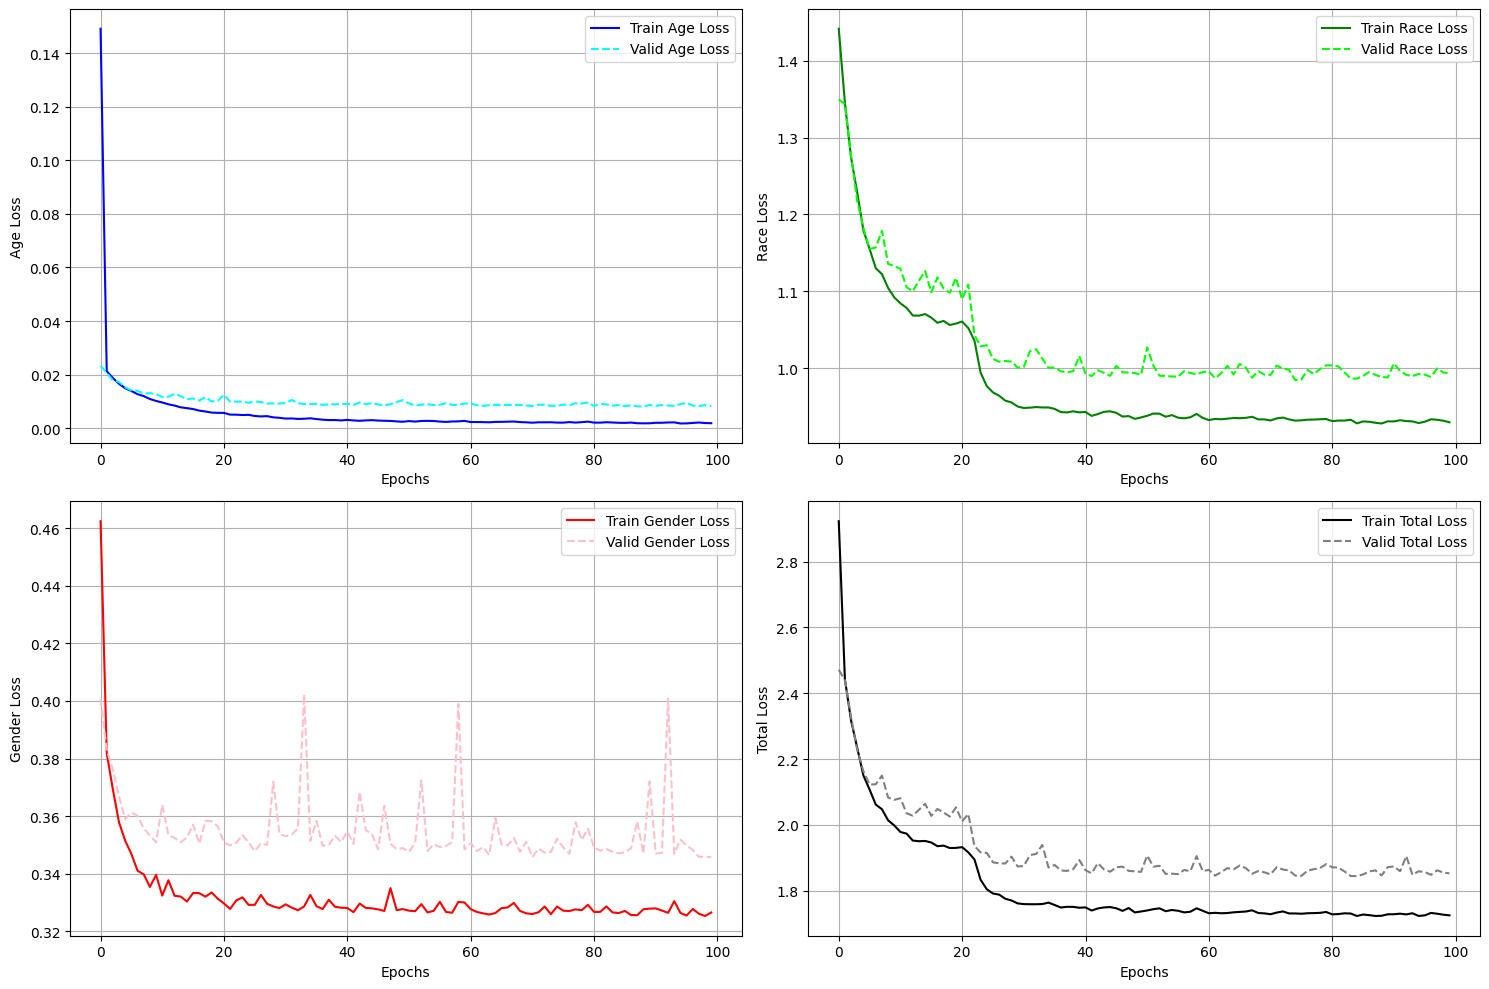

In [44]:
# Plotting the loss curves

plt.figure(figsize=(15, 10))

# Age Loss curve
plt.subplot(2, 2, 1)
plt.plot(train_loss_age, label='Train Age Loss', color='blue')
plt.plot(valid_loss_age, label='Valid Age Loss', color='cyan', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Age Loss')
plt.legend()
plt.grid(True)

# Race Loss curve
plt.subplot(2, 2, 2)
plt.plot(train_loss_race, label='Train Race Loss', color='green')
plt.plot(valid_loss_race, label='Valid Race Loss', color='lime', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Race Loss')
plt.legend()
plt.grid(True)

# Gender Loss curve
plt.subplot(2, 2, 3)
plt.plot(train_loss_gender, label='Train Gender Loss', color='red')
plt.plot(valid_loss_gender, label='Valid Gender Loss', color='pink', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Gender Loss')
plt.legend()
plt.grid(True)

# Total Loss curve
plt.subplot(2, 2, 4)
plt.plot(train_total_loss, label='Train Total Loss', color='black')
plt.plot(valid_total_loss, label='Valid Total Loss', color='gray', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Total Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [23]:
model_directory = "/kaggle/working/customCNN/"
os.makedirs(model_directory, exist_ok = True)

model_path = model_directory+"model_weights.pt"
torch.save(model, model_path)

In [27]:
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error

# Lists to store true labels and predictions
true_ages, pred_ages = [], []
true_races, pred_races = [], []
true_genders, pred_genders = [], []

# Set the model to evaluation mode
model.eval()

# Disable gradient computation
with torch.no_grad():
    for images, ages, races, genders in valid_loader:  # Assuming you have a validation loader called 'val_loader'
        images = images.float().to(device)

        # Get predictions
        age_preds, race_preds, gender_preds = model(images)

        # Convert predictions to class labels
        _, predicted_races = torch.max(race_preds, 1)
        _, predicted_genders = torch.max(gender_preds, 1)

        # Append true labels and predicted labels
        true_ages.extend(ages.cpu().numpy())
        pred_ages.extend(age_preds.squeeze(1).cpu().numpy())

        true_races.extend(torch.argmax(races, dim=1).cpu().numpy())
        pred_races.extend(predicted_races.cpu().numpy())

        true_genders.extend(torch.argmax(genders, dim=1).cpu().numpy())
        pred_genders.extend(predicted_genders.cpu().numpy())

# Generate classification reports
print("Classification report for Age:")
print("True Ages:", true_ages[:10])
print("Predicted Ages:", pred_ages[:10])

# print("\nClassification report for Age:")
# print(classification_report(true_ages, pred_ages))

# Report for Age:
print("Report for Age:")
mae = mean_absolute_error(true_ages, pred_ages)
mse = mean_squared_error(true_ages, pred_ages)
print(f"Mean Absolute Error for Age: {mae:.4f}")
print(f"Mean Squared Error for Age: {mse:.4f}")

print("\nClassification report for Race:")
print(classification_report(true_races, pred_races))

print("\nClassification report for Gender:")
print(classification_report(true_genders, pred_genders))

Classification report for Age:
True Ages: [0.9565217391304348, 0.5362318840579711, 0.8840579710144928, 0.17391304347826086, 0.391304347826087, 0.7246376811594203, 0.4927536231884058, 0.7536231884057971, 0.5217391304347826, 0.37681159420289856]
Predicted Ages: [0.7020356, 0.6237755, 0.7847971, 0.32346636, 0.50223124, 0.5419551, 0.40947866, 0.68240196, 0.5975906, 0.39424756]
Report for Age:
Mean Absolute Error for Age: 0.0737
Mean Squared Error for Age: 0.0108

Classification report for Race:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      2312
           1       0.90      0.94      0.92      1648
           2       0.92      0.93      0.92       852
           3       0.78      0.92      0.84      1353
           4       0.00      0.00      0.00       514

    accuracy                           0.85      6679
   macro avg       0.69      0.74      0.71      6679
weighted avg       0.79      0.85      0.82      6679


Classification

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


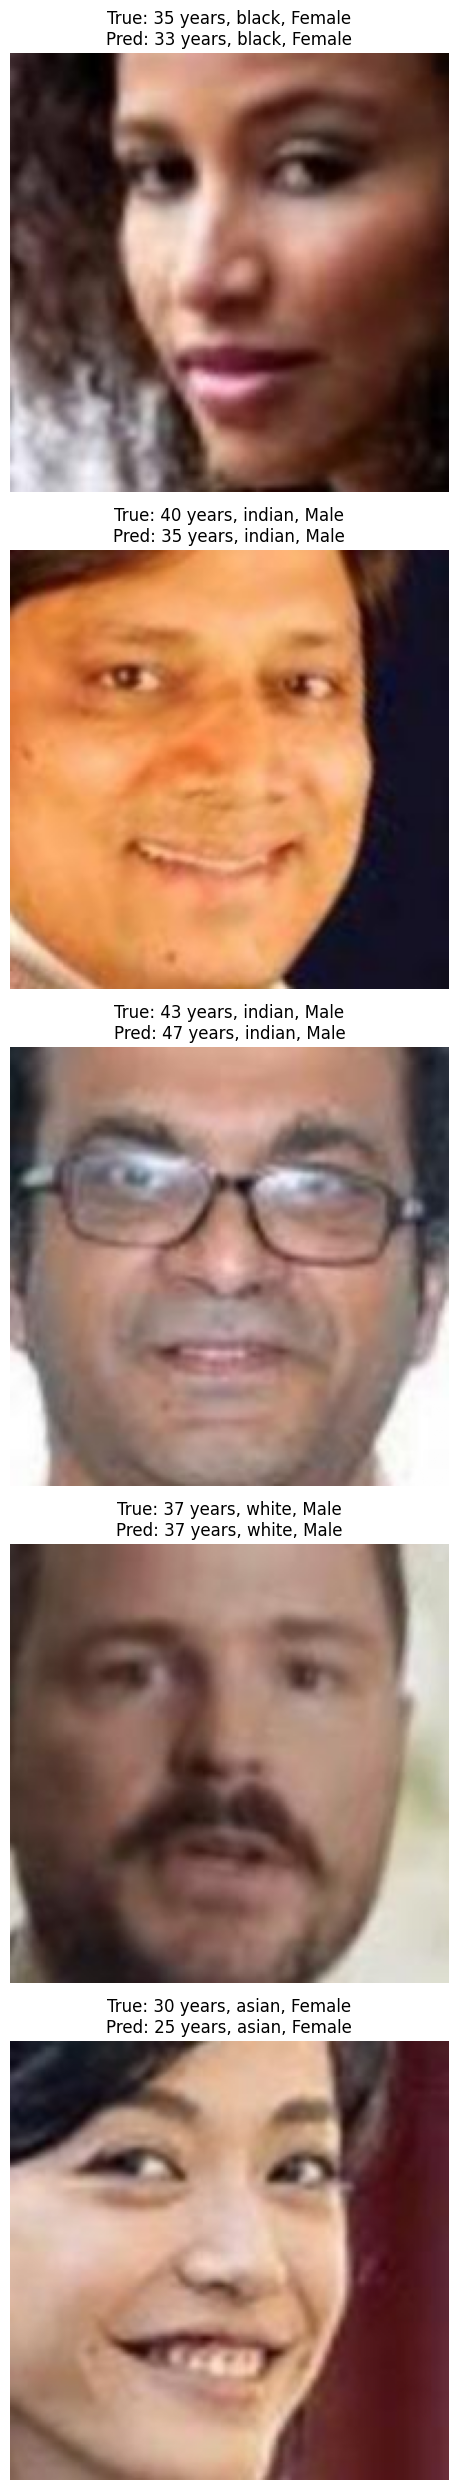

In [36]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, loader, num_images=5):
    model.eval()
    image_count = 0
    fig, axs = plt.subplots(num_images, figsize=(10, 5 * num_images))

    with torch.no_grad():
          for images, ages, races, genders in loader:
            if image_count >= num_images:
#         for idx, (images, ages, races, genders) in enumerate(loader):
#             if idx == num_images:
                break

            images = images.float().to(device)
            age_preds, race_preds, gender_preds = model(images)

            _, predicted_races = torch.max(race_preds, 1)
            _, predicted_genders = torch.max(gender_preds, 1)

            for i in range(images.size(0)):
                if image_count >= num_images:
                    break
            # Convert the predictions back to the label names
            pred_age = int(age_preds[i].squeeze().item() * max_age)
            true_age = int(ages[i].item() * max_age)

            
#             pred_race = REVERSE_RACE_ID_MAP[predicted_races.item()]  
#             true_race = REVERSE_RACE_ID_MAP[torch.argmax(races, dim=1).item()]

            pred_race = ID_RACE_MAP[predicted_races[i].item()]
            true_race = ID_RACE_MAP[torch.argmax(races[i], dim=0).item()]


#             pred_gender = "Male" if predicted_genders.item() == 1 else "Female"
#             true_gender = "Male" if torch.argmax(genders, dim=1).item() == 1 else "Female"
            pred_gender = "Female" if predicted_genders[i].item() == 1 else "Male"
            true_gender = "Female" if torch.argmax(genders[i], dim=0).item() == 1 else "Male"
                
            # Plotting the image with predictions and true labels
#             axs[idx].imshow(np.transpose(images[0].cpu().numpy(), (1, 2, 0)))
#             axs[idx].axis('off')
#             axs[idx].set_title(f"True: {true_age} years, {true_race}, {true_gender}\nPred: {pred_age} years, {pred_race}, {pred_gender}")
            axs[image_count].imshow(np.transpose(images[i].cpu().numpy(), (1, 2, 0)))
            axs[image_count].axis('off')
            axs[image_count].set_title(f"True: {true_age} years, {true_race}, {true_gender}\nPred: {pred_age} years, {pred_race}, {pred_gender}")
                
            image_count += 1

    plt.tight_layout()
    plt.show()

# Visualize the predictions on the validation dataset
visualize_predictions(model, valid_loader)